<a href="https://colab.research.google.com/github/kindeerrrr/first_repository/blob/main/kmo_sessia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт

Мы подключаем:
-	numpy и pandas — работа с массивами и таблицами
-	scipy — для статистики (асимметрия, пиковость, корреляции)
-	sklearn — всё для нормализации, снижения размерности и кластеризации
-	matplotlib.pyplot — для финальной красивой картинки

In [87]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.signal import correlate

# Загрузка и первичный анализ
-	Пробуем открыть текстовый файл с сигналами
-	Сначала через табуляцию, если не сработало — через пробелы
-	Если всё упало — выводим ошибку
-	Сразу смотрим, сколько у нас строк и столбцов, и как выглядит начало файла

In [96]:
file_path = 'Run200_Wave_0_1.txt'
# Попробуем сначала через табуляцию
try:
    df = pd.read_csv(file_path, delimiter='\t', header=None)
    if df.shape[1] == 1:  # всё еще не разбилось — пробуем пробелы
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
except Exception as e:
    print("Ошибка чтения:", e)

print("Форма таблицы после чтения:", df.shape)
print(df.head(2))

# Посмотрим на размер и типы данных
print("Размер датасета:", df.shape)
print("\nТипы данных:")
print(df.dtypes)


<ipython-input-96-1500384098>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Форма таблицы после чтения: (23479, 504)
       0    1    2    3      4      5      6      7      8      9    ...  \
0  2890276  357  113  500  14820  14823  14824  14822  14818  14820  ...   
1  4928764  740  359  500  14820  14822  14820  14826  14824  14822  ...   

     494    495    496    497    498    499    500    501    502    503  
0  14828  14822  14815  14815  14817  14819  14820  14822  14820  14819  
1  14828  14817  14824  14822  14824  14819  14820  14819  14822  14820  

[2 rows x 504 columns]
Размер датасета: (23479, 504)

Типы данных:
0      int64
1      int64
2      int64
3      int64
4      int64
       ...  
499    int64
500    int64
501    int64
502    int64
503    int64
Length: 504, dtype: object


<ipython-input-96-1500384098>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_clean = df.applymap(lambda x: float(str(x).replace("'", "").replace(",", ".").strip()) if pd.notnull(x) else np.nan)



После очистки типов:
float64    504
Name: count, dtype: int64


# Преобразование признаков из object в числовые
Данные сначала как строки — чистим их: убираем лишние символы (кавычки, запятые), превращаем в числа. Удаляем столбцы, в которых вообще нет данных. Все пустоты заполняем медианой. Превращаем в массив float32

In [ ]:
# Очистка: убираем кавычки, пробелы, запятые — всё превращаем в числа
df_clean = df.applymap(lambda x: float(str(x).replace("'", "").replace(",", ".").strip()) if pd.notnull(x) else np.nan)

# Проверим типы
print("\nПосле очистки типов:")
print(df_clean.dtypes.value_counts())

df_clean.dropna(axis=1, how='all', inplace=True)
df_clean.fillna(df_clean.median(), inplace=True)

waveforms = df_clean.values.astype(np.float32)

# Функция extract_features

-	Очищаем сигнал от NaN и бесконечностей, обрезаем бешеные значения
-	Если сигнал плоский (всё одинаково) — возвращаем нули
-	Считаем базовую статистику: среднее, разброс, макс/мин, индекс максимума
-	Асимметрия (skew) и пиковость (kurtosis)
-	Энергия сигнала и площадь под ним
-	Производная: насколько резко меняется сигнал
-	Автокорреляция: насколько он похож сам на себя сдвинутый
-	Делим сигнал на 3 части, считаем энергию каждой
-	FFT — преобразуем сигнал в частоты, берём максимум и среднее
-	Логарифмируем некоторые штуки для стабилизации

In [106]:
# === Функция извлечения признаков ===
def extract_features(signal):
    signal = np.asarray(signal)

    # Очистка от NaN и бесконечностей
    signal = np.nan_to_num(signal, nan=0.0, posinf=0.0, neginf=0.0)
    signal = np.clip(signal, -1e6, 1e6)

    if np.allclose(signal, signal[0]):
        return [0.0] * 24

    try:
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        max_val = np.max(signal)
        min_val = np.min(signal)
        argmax_val = np.argmax(signal)
        skewness = skew(signal)
        kurt = kurtosis(signal)
        energy = np.sum(signal ** 2)
        area = np.sum(signal)

        # Производная
        diff = np.diff(signal)
        diff_mean = np.mean(diff)
        diff_std = np.std(diff)

        # Автокорреляция на лагах 1–3
        def autocorr(x, lag):
            return np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else 0

        acf1 = autocorr(signal, 1)
        acf2 = autocorr(signal, 2)
        acf3 = autocorr(signal, 3)

        # Энергия по зонам
        thirds = np.array_split(signal, 3)
        energy_parts = [np.sum(part ** 2) for part in thirds]

        # FFT
        fft_vals = np.fft.fft(signal)
        fft_power = np.abs(fft_vals[1:len(signal)//2])
        fft_max = np.max(fft_power)
        fft_mean = np.mean(fft_power)

        # Лог-признаки
        safe = lambda x: np.log1p(abs(x))
        return [
            mean_val, std_val, max_val, min_val, argmax_val,
            skewness, kurt, energy, area,
            diff_mean, diff_std,
            acf1, acf2, acf3,
            *energy_parts,
            fft_max, fft_mean,
            safe(mean_val), safe(std_val), safe(energy), safe(fft_max)
        ]
    except Exception as e:
        print("Ошибка на сигнале:", e)
        return [0.0] * 24

# Извлекаем признаки для всех сигналов
1.	Прогоняем каждый сигнал через extract_features, получаем таблицу X.
2.  Проверяем, нет ли сломанных данных (NaN и бесконечностей).
3.  Масштабируем оригинальные сигналы (а не фичи!) — чтобы они были на одной шкале.
4.	Применяем PCA — понижаем размерность до 15 признаков, чтобы проще визуализировать и обрабатывать.

In [107]:
# Извлечение
X = np.array([extract_features(row) for row in waveforms])
print(X.shape)

# Проверка на NaN/Inf
print("NaN:", np.any(np.isnan(X)), "Inf:", np.any(np.isinf(X)))

# Масштабируем сами сигналы
scaler = StandardScaler()
X_scaled = scaler.fit_transform(waveforms)

# PCA на 15 компонентов
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

(23479, 23)
NaN: False Inf: False


# Кластеризация

In [108]:
# === Кластеризация KMeans ===
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
score_kmeans = silhouette_score(X_scaled, kmeans_labels)

In [109]:
# === Кластеризация GMM ===
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
score_gmm = silhouette_score(X_scaled, gmm_labels)

# Сравнение моделей
1. 	Сравниваем силуэт-оценки от KMeans и GMM.
2.	Берём ту модель, что показала себя лучше.
3.	Копируем очищенный датафрейм и добавляем в него колонку с метками кластеров.


In [110]:
# === Выбор лучшей модели ===
if score_kmeans >= score_gmm:
    best_labels = kmeans_labels
    best_model = 'KMeans'
    best_score = score_kmeans
else:
    best_labels = gmm_labels
    best_model = 'GMM'
    best_score = score_gmm

# === Сбор и сохранение результата ===
df_result = df_clean.copy()
df_result['cluster'] = best_labels

submission = pd.DataFrame({
    'index': df_result.index,
    'cluster': df_result['cluster']
})

submission.to_csv('submission_best.csv', index=False)

print(f" Сохранён результат модели {best_model} в submission_best.csv")

 Сохранён результат модели KMeans в submission_best.csv


# Визуализация

-	Рисуем график, где каждая точка — это сигнал, спроецированный на 2 главные оси PCA.
-	Цветом обозначен кластер.
-	Видно, как модель разделила сигналы — в идеале это должны быть чёткие “облака”.

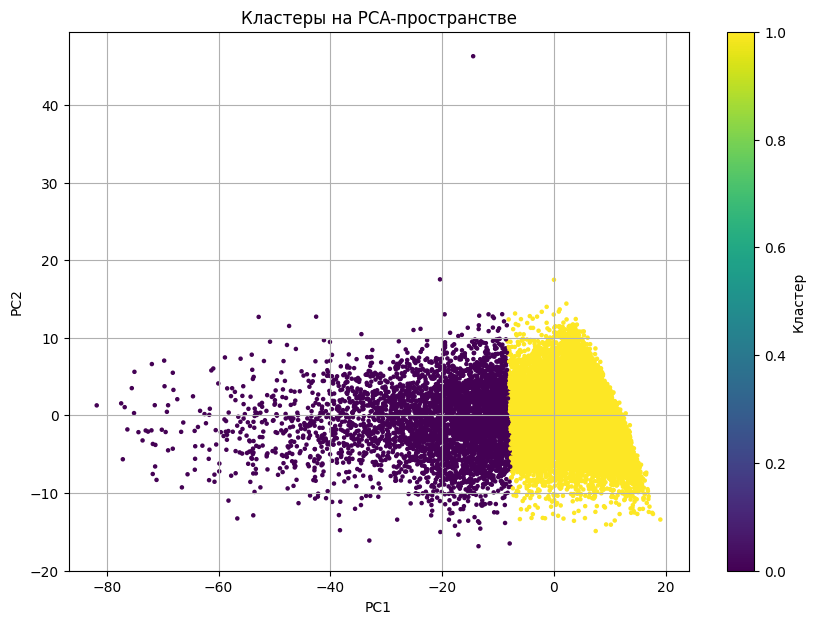

In [111]:
# Визуализация
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', s=5)
plt.title("Кластеры на PCA-пространстве")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(label='Кластер')
plt.show()

# Результат в Kaggle

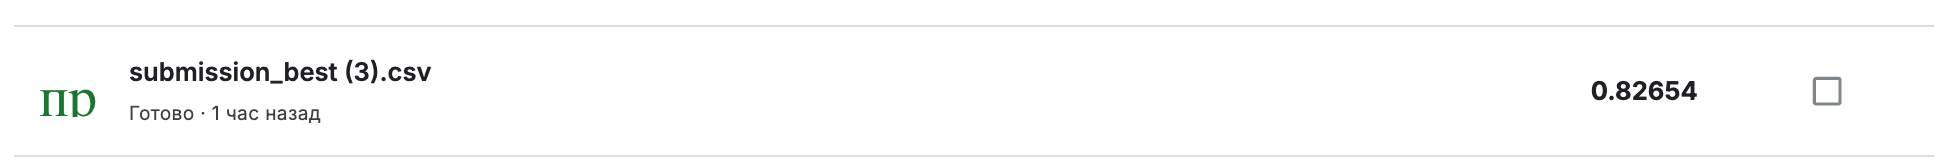